# sklearn-LDA

## 1.预处理

In [1]:
import os
import pandas as pd
import re
import jieba
import jieba.posseg as psg

In [2]:
output_path = 'C:/Users/cjm34/Desktop/lda/result'
file_path = 'C:/Users/cjm34/Desktop/lda/data'
os.chdir(file_path)
data=pd.read_excel("after.xlsx")#content type
os.chdir(output_path)
dic_file = "C:/Users/cjm34/Desktop/lda/stop_dic/dict.txt"
stop_file = "C:/Users/cjm34/Desktop/lda/stop_dic/stopwords.txt"

In [3]:
def chinese_word_cut(mytext):
    jieba.load_userdict(dic_file)
    jieba.initialize()
    try:
        stopword_list = open(stop_file,encoding ='utf-8')
    except:
        stopword_list = []
        print("error in stop_file")
    stop_list = []
    flag_list = ['n','nz','vn']
    for line in stopword_list:
        line = re.sub(u'\n|\\r', '', line)
        stop_list.append(line)
    
    word_list = []
    #jieba分词
    seg_list = psg.cut(mytext)
    for seg_word in seg_list:
        word = re.sub(u'[^\u4e00-\u9fa5]','',seg_word.word)
        #word = seg_word.word  #如果想要分析英语文本，注释这行代码，启动下行代码
        find = 0
        for stop_word in stop_list:
            if stop_word == word or len(word)<2:     #this word is stopword
                    find = 1
                    break
        if find == 0 and seg_word.flag in flag_list:
            word_list.append(word)      
    return (" ").join(word_list)

In [4]:
data["content_cutted"] = data.content.apply(chinese_word_cut)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\cjm34\AppData\Local\Temp\jieba.cache
Loading model cost 0.364 seconds.
Prefix dict has been built successfully.


## 2.LDA分析

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [6]:
def print_top_words(model, feature_names, n_top_words):
    tword = []
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        topic_w = " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        tword.append(topic_w)
        print(topic_w)
    return tword

In [7]:
n_features = 1000 #提取1000个特征词语
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                max_features=n_features,
                                stop_words='english',
                                max_df = 0.5,
                                min_df = 10)
tf = tf_vectorizer.fit_transform(data.content_cutted)

In [8]:
n_topics = 2
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=50,
                                learning_method='batch',
                                learning_offset=50,
#                                 doc_topic_prior=0.1,  #α
#                                 topic_word_prior=0.01,    #β
                               random_state=0)
lda.fit(tf)

LatentDirichletAllocation(learning_offset=50, max_iter=50, n_components=2,
                          random_state=0)

### 2.1输出每个主题对应词语 

In [9]:
n_top_words = 15
tf_feature_names = tf_vectorizer.get_feature_names()
topic_word = print_top_words(lda, tf_feature_names, n_top_words)

Topic #0:
症状 口罩 医院 抗原 孩子 核酸 感觉 身体 视频 生活 结果 老人 朋友 新冠 居家
Topic #1:
新冠 病毒 国家 防控 政策 防疫 经济 核酸 管控 问题 影响 生活 政府 原因 情况


D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### 2.2输出每篇文章对应主题 

In [10]:
import numpy as np

In [11]:
topics=lda.transform(tf)

In [12]:
topic = []
for t in topics:
    topic.append("Topic #"+str(list(t).index(np.max(t))))
data['概率最大的主题序号']=topic
data['每个主题对应概率']=list(topics)
data.to_excel("data_topic.xlsx",index=False)

### 2.3可视化 

In [13]:
import pyLDAvis
import pyLDAvis.sklearn

In [14]:
pyLDAvis.enable_notebook()
pic = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)
pyLDAvis.display(pic)
pyLDAvis.save_html(pic, 'lda_pass'+str(n_topics)+'.html')
pyLDAvis.display(pic)
#去工作路径下找保存好的html文件
#和视频里讲的不一样，目前这个代码不需要手动中断运行，可以快速出结果

D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\cjm34\AppData\Roaming\Python\Python39\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


### 2.4困惑度 

In [15]:
import matplotlib.pyplot as plt

In [16]:
plexs = []
scores = []
n_max_topics = 16
for i in range(1,n_max_topics):
    print(i)
    lda = LatentDirichletAllocation(n_components=i, max_iter=50,
                                    learning_method='batch',
                                    learning_offset=50,random_state=0)
    lda.fit(tf)
    plexs.append(lda.perplexity(tf))
    scores.append(lda.score(tf))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


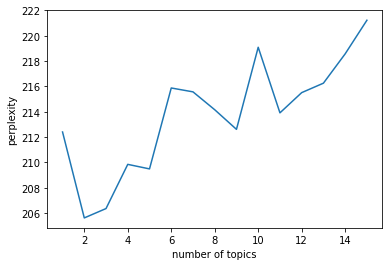

In [17]:
n_t=15#区间最右侧的值。注意：不能大于n_max_topics
x=list(range(1,n_t+1))
plt.plot(x,plexs[0:n_t])
plt.xlabel("number of topics")
plt.ylabel("perplexity")
plt.show()